# Исследование тарифных планов мобильного оператора связи

Федеральный оператор сотовой связи дал задание провести исследование двух тарифных планов - «Смарт» и «Ультра». Чтобы правильно распланировать бюждет на рекламу, коммерческий департамент хочет знать, какой их этих тарифов приносит больше всего выручки.
Мне предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов оператора. В распоряжении имеются данные пятисот пользователей: имя, город, тариф, дата регистрации, данные о количестве звонков, сообщений и прочее. Требуется проанализировать поведение пользователей и определить лучший из этих двух тарифов.

### Описание тарифов

Тариф «Смарт»

> Ежемесячная плата: 550 рублей
> Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
> Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля; 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

Тариф «Ультра»

> Ежемесячная плата: 1950 рублей
> Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
> Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.


Важное примечание для исследования:
Оператор округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитана минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Знакомство с данными из файлов

Имеются 5 файлов с данными - calls.csv, internet.csv, messages.csv, tariffs.csv и users.csv.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt #импорт библиотеки для построения графиков
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
calls.info()
calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Таблица **calls** содержит информацию о звонках, состоит из столбцов:
*id* — уникальный номер звонка (формат object);
*call_date* — дата звонка (формат object);
*duration* — длительность звонка в минутах (формат float);
*user_id* — идентификатор пользователя, сделавшего звонок (формат int).

Пропущенных данных не имеется. Есть нулевые значения в колонке продолжильность звонка - это пропущенные вызовы.


In [2]:
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv', index_col=0)
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


Таблица **internet** содержит информацию об интернет сессиях, состоит из столбцов:
*Unnamed: 0* - столбец, повторяющий значения столбца с индексами, не несёт никакой дополнительной информации;
*id* — уникальный номер сессии (формат object);
*mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах) (формат float);
*session_date* — дата интернет-сессии (формат object);
*user_id* — идентификатор пользователя (формат int);

Имеется большое количество интернет-сессий у разных пользователей с нулевым значением трафика. Скорее всего, мобильный оператор считает и входящий, и исходящий трафик внутри сессии. Так же известно, что отсутствие средств на счёте тоже не может являться причиной, так как оператор высчитывает сумму для списания в конце месяца. Оставшиеся причины нулевых сессий - это ошибки подключения, перегрузка и сбои сети. Данные записи не повлияют на наши расчёты и исследование, но могут пригодится для других. Поэтому удалять сессии с нулевыми значениями не нужно.

In [3]:
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
messages.info()
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


Таблица **messages** содержит информацию о сообщениях, включает следующие столбцы:
*id* — уникальный номер сообщения (формат object);
*message_date* — дата сообщения (формат object);
*user_id* — идентификатор пользователя, отправившего сообщение(формат int);

Пропусков данных не имеется.

In [4]:
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица **tariffs** содержит только две записи - тарифы двух тарифных планов, с такими параметрами как:
1. *tariff_name* — название тарифа
2. *rub_monthly_fee* — ежемесячная абонентская плата в рублях
3. *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
4. *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
5. *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
6. *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
7. *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
8. *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

In [5]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')
users.info()
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Таблица **users** содержит информацию о пользователях, состоит из столбцов:
*Unnamed: 
1. *user_id* — уникальный идентификатор пользователя (тип данных int)
2. *age* — возраст пользователя (годы) (тип данных int)
3. *first_name* — имя пользователя (тип данных object)
4. *last_name* — фамилия пользователя (тип данных object)
5. *reg_date* — дата подключения тарифа (день, месяц, год) (тип данных object)
6. *churn_date* — дата прекращения пользования тарифом (тип данных object)
7. *city* — город проживания пользователя (тип данных object)
8. *tarif* — название тарифного плана (тип данных object)

Пропусков в данных нет, кроме столбца *churn_date* - здесь пропуски означают, что тариф используется на данный момент.

## Предподготовка данных
### Изменение формата данных
Для начала столбцы с датой из всех столбцов переведём из формата object в стандартный формат даты datetime - только месяц и год (так как мы будем использовать сгрупированные данные по месяцам, дни нам не нужны).

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d').dt.to_period('M')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d').dt.to_period('M')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d').dt.to_period('M')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d').dt.to_period('M') #перевод столбцов в формат datetime

In [7]:
calls['duration'] = np.ceil(calls['duration']).astype('int') #так как Мегалайн округляет звонки вверх до минуты, переведём столбец длительность звонка в формат int с округлением вверх

### Расчёты и добавление данных
Необходимо посчитать для каждого пользователя:
1. Количество сделанных звонков и израсходованных минут разговора по месяцам;
2. Количество отправленных сообщений по месяцам;
3. Объем израсходованного интернет-трафика по месяцам;
4. Помесячную выручку с каждого пользователя (вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножить на значение из тарифного плана; прибавить абонентскую плату, соответствующую тарифному плану).

In [8]:
user_pivot = calls.pivot_table(index=['user_id', 'call_date'], values=['duration'], aggfunc=['count', 'sum']) #подсчёт кол-ва и длительности звонков пользователей по месяцам
user_pivot.set_axis(['calls_count', 'total_duration'],axis = 'columns',inplace = True) #переименование столбцов
user_pivot['messages'] = messages.pivot_table(index=['user_id', 'message_date'], values='id', aggfunc='count')['id'] #добавление кол-ва отправленных сообщений
user_pivot['traffic_mb'] = internet.pivot_table(index=['user_id', 'session_date'], values='mb_used', aggfunc='sum')['mb_used'] #суммирование месячного интернет-траффика
user_pivot.reset_index(inplace=True) #перевод мильтииндекса в столбцы для дальнейших расчётов
user_pivot = user_pivot.merge(users[['user_id', 'tariff', 'city']], on='user_id') #присоединяем к таблице тарифный план и город
user_pivot.rename(columns = {'call_date' : 'month'}, inplace = True)
user_pivot

,user_id,month,calls_count,total_duration,messages,traffic_mb,tariff,city
0,1000,2018-05,22,159,22.0,2253.49,ultra,Краснодар
1,1000,2018-06,43,172,60.0,23233.77,ultra,Краснодар
2,1000,2018-07,47,340,75.0,14003.64,ultra,Краснодар
3,1000,2018-08,52,408,81.0,14055.93,ultra,Краснодар
4,1000,2018-09,58,466,57.0,14568.91,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3169,1498,2018-10,41,247,42.0,20579.36,smart,Владикавказ
3170,1499,2018-09,9,70,11.0,1845.75,smart,Пермь
3171,1499,2018-10,68,449,48.0,17788.51,smart,Пермь
3172,1499,2018-11,74,612,59.0,17963.31,smart,Пермь


In [9]:
def calculation(row): #создаём функцию для расчёта месячного расхода пользователей
  if row['tariff'] == 'smart': #если тариф smart, расчёт ниже
    call_price = 0
    sms_price = 0
    int_price = 0
    if row['total_duration'] > 500: #проверка выхода за лимиты по звонкам
        call_price = (row['total_duration'] - 500)*3
    if row['messages'] > 50: #проверка выхода за лимиты по сообщениям
        sms_price = (row['messages']-50)*3
    if row['traffic_mb'] > 15360: #проверка выхода за лимит траффика
        int_price = math.ceil(row['traffic_mb']/1024-15) * 200 #округление вверх до Гб и умножение на цену
    earn = 550 + call_price + sms_price + int_price #абонентская плата + расходы свыше лимитов
    return earn
  else: #если не smart, то расчёт по тариф ultra (так как других тарифов нет)
    call_price = 0
    sms_price = 0
    int_price = 0
    if row['total_duration'] > 3000:
        call_price = row['total_duration'] - 3000
    if row['messages'] > 1000:
        sms_price = row['messages']-1000
    if row['traffic_mb'] > 30720:
        int_price = math.ceil(row['traffic_mb']/1024-30) * 150
    earn = 1950 + call_price + sms_price + int_price
    return earn
user_pivot['earning'] = user_pivot.apply(calculation, axis=1) #применяем функцию и создаём новый столбец в сводной таблице
user_pivot

,user_id,month,calls_count,total_duration,messages,traffic_mb,tariff,city,earning
0,1000,2018-05,22,159,22.0,2253.49,ultra,Краснодар,1950.0
1,1000,2018-06,43,172,60.0,23233.77,ultra,Краснодар,1950.0
2,1000,2018-07,47,340,75.0,14003.64,ultra,Краснодар,1950.0
3,1000,2018-08,52,408,81.0,14055.93,ultra,Краснодар,1950.0
4,1000,2018-09,58,466,57.0,14568.91,ultra,Краснодар,1950.0
...,...,...,...,...,...,...,...,...,...
3169,1498,2018-10,41,247,42.0,20579.36,smart,Владикавказ,1750.0
3170,1499,2018-09,9,70,11.0,1845.75,smart,Пермь,550.0
3171,1499,2018-10,68,449,48.0,17788.51,smart,Пермь,1150.0
3172,1499,2018-11,74,612,59.0,17963.31,smart,Пермь,1513.0


### Вывод

Выполнил предподготовку данных во всех таблицах, привёл данные к нужным для исследования форматам. Создал сводную таблицу с расчётом количества и продолжительности звонков, количества сообщений и суммарно потраченного интернет-траффика для каждого пользователя мобильного оператора помесячно. С помощью этих данных успешно рассчитал помесячную выручку с каждого пользователя и добавил эти данные в сводную таблицу.

## 3. Анализ данных

Необходимо описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы и описать распределения.

'Среднее количество сообщений в месяц:'

tariff
smart    38.747390
ultra    61.195538
Name: messages, dtype: float64

Дисперсия количества сообщений тарифа smart 718.7973574905967
Дисперсия количества сообщений тарифа ultra 1996.9499538443522
Стандартное отклонение количества сообщений тарифа smart 26.810396444114673
Стандартное отклонение количества сообщений тарифа ultra 44.68724598634774


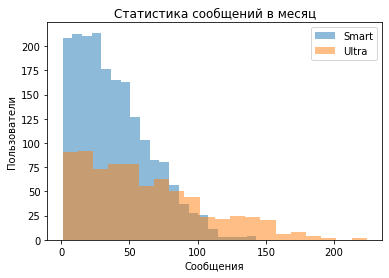

In [10]:
#выделим в отдельные таблицы разные тарифы
smart_pivot = user_pivot.query('tariff == "smart"') 
ultra_pivot = user_pivot.query('tariff == "ultra"')

display('Среднее количество сообщений в месяц:', user_pivot.groupby('tariff')['messages'].mean())
print('Дисперсия количества сообщений тарифа smart', 
      np.var(smart_pivot['messages']))
print('Дисперсия количества сообщений тарифа ultra', 
      np.var(ultra_pivot['messages']))
print('Стандартное отклонение количества сообщений тарифа smart', 
      np.std(smart_pivot['messages']))
print('Стандартное отклонение количества сообщений тарифа ultra', 
      np.std(ultra_pivot['messages']))

plt.hist(smart_pivot['messages'], bins=20, alpha=0.5, label='Smart')
plt.hist(ultra_pivot['messages'], bins=20, alpha=0.5, label='Ultra')
plt.legend(loc='upper right')
plt.xlabel('Сообщения')
plt.ylabel('Пользователи')
plt.title('Статистика сообщений в месяц')
plt.show()


В среднем ежемесячно пользователи тарифа ultra отправляют в полтора раза больше сообщений. Но в целом для обоих тарифов велика доля и тех, кто отправляет совсем мало сообщений, вплоть до нуля. Распределение у обоих графиков нормальное, у для тарифа Ultra выше разброс данных (так как количество пользователей меньше).

'Среднее количество минут разговора в месяц:'

tariff
smart    419.062978
ultra    545.451104
Name: total_duration, dtype: float64

Дисперсия минут разговора тарифа smart 35828.06530953033
Дисперсия минут разговора тарифа ultra 94104.36117385984
Стандартное отклонение минут разговора тарифа smart 189.2830296395594
Стандартное отклонение минут разговора тарифа ultra 306.76434143143143


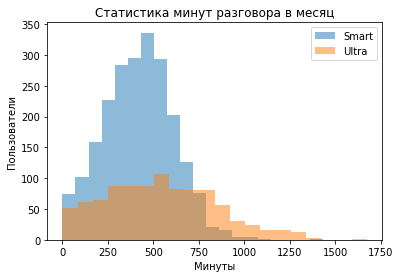

In [11]:
display('Среднее количество минут разговора в месяц:', 
        user_pivot.groupby('tariff')['total_duration'].mean())
print('Дисперсия минут разговора тарифа smart', 
      np.var(smart_pivot['total_duration']))
print('Дисперсия минут разговора тарифа ultra', 
      np.var(user_pivot.query('tariff == "ultra"')['total_duration']))
print('Стандартное отклонение минут разговора тарифа smart', 
      np.std(smart_pivot['total_duration']))
print('Стандартное отклонение минут разговора тарифа ultra', 
      np.std(ultra_pivot['total_duration']))

plt.hist(smart_pivot['total_duration'], bins=20, alpha=0.5, label='Smart')
plt.hist(ultra_pivot['total_duration'], bins=20, alpha=0.5, label='Ultra')
plt.legend(loc='upper right')
plt.xlabel('Минуты')
plt.ylabel('Пользователи')
plt.title('Статистика минут разговора в месяц')
plt.show()

Если анализировать длительность звонков в течение месяца - здесь также, в среднем у пользователей тарифа Ultra этот показатель выше, но выше и разброс данных, в том числе доля тех, кто тратит совсем немного минут. Распределение значений на гистограммах нормальное.

'Среднее количество интернет-траффика в месяц:'

tariff
smart    16216.661274
ultra    19669.283603
Name: traffic_mb, dtype: float64

Дисперсия количества интернет-траффика тарифа smart 34412098.457164586
Дисперсия количества интернет-траффика тарифа ultra 99465187.55618353
Стандартное отклонение количества интернет-траффика тарифа smart 5866.18261369049
Стандартное отклонение количества интернет-траффика тарифа ultra 9973.223528838784


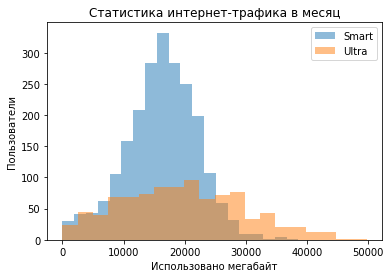

In [12]:
display('Среднее количество интернет-траффика в месяц:', 
        user_pivot.groupby('tariff')['traffic_mb'].mean())
print('Дисперсия количества интернет-траффика тарифа smart', 
      np.var(smart_pivot['traffic_mb']))
print('Дисперсия количества интернет-траффика тарифа ultra', 
      np.var(ultra_pivot['traffic_mb']))
print('Стандартное отклонение количества интернет-траффика тарифа smart', 
      np.std(smart_pivot['traffic_mb']))
print('Стандартное отклонение количества интернет-траффика тарифа ultra', 
      np.std(ultra_pivot['traffic_mb']))

plt.hist(smart_pivot['traffic_mb'], bins=20, alpha=0.5, label='Smart')
plt.hist(ultra_pivot['traffic_mb'], bins=20, alpha=0.5, label='Ultra')
plt.legend(loc='upper right')
plt.xlabel('Использовано мегабайт')
plt.ylabel('Пользователи')
plt.title('Статистика интернет-трафика в месяц')
plt.show()

Здесь также у обоих гистограмм нормальное распределение. В среднем пользователи Ultra тратят больше интернет-трафика за месяц. Также тут видно, большинство пользователей Smart выходит за лимит трафика, включённого в абонентскую плату.

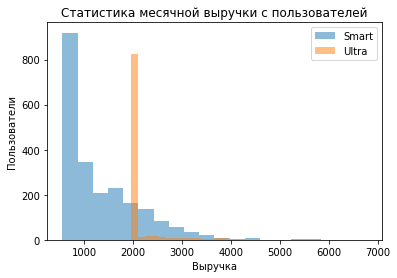

In [13]:
#построим график месячной выручки с пользователей по разным тарифам.
plt.hist(smart_pivot['earning'], bins=20, alpha=0.5, label='Smart')
plt.hist(ultra_pivot['earning'], bins=20, alpha=0.5, label='Ultra')
plt.legend(loc='upper right')
plt.xlabel('Выручка')
plt.ylabel('Пользователи')
plt.title('Статистика месячной выручки с пользователей')
plt.show()

Здесь видно, что немаленькая часть пользователей тарифа Smart платит в месяц больше своей абонентской платы, как как выходит лимиты тарифа (в основном за счёт интернета). На тарифе Ultra пользователи платят в месяц в подавляющем числе случаев ровно абонентскую плату 1950.

### Вывод

Посчитал средние значения, стандартное отклонение, дисперсию для количества сообщений, длительности звонков и потраченных мегабайт траффика за месяц для пользователей обоих тарифов.
Вывел гистограммы, описал данные.

## Проверка гипотез

Для начала изучим две совокупности данных - средней выручке от пользователей обоих тарифов.

In [14]:
display('Средняя выручка с пользователя в месяц:', 
        user_pivot.groupby('tariff')['earning'].mean())
print('Дисперсия выручки тарифа smart', 
      np.var(smart_pivot['earning']))
print('Дисперсия выручки тарифа ultra', 
      np.var(ultra_pivot['earning']))
print('Стандартное отклонение выручки тарифа smart', 
      np.std(smart_pivot['earning']))
print('Стандартное отклонение выручки тарифа ultra', 
      np.std(ultra_pivot['earning']))

'Средняя выручка с пользователя в месяц:'

tariff
smart    1290.891138
ultra    2070.977918
Name: earning, dtype: float64

Дисперсия выручки тарифа smart 670655.5077172383
Дисперсия выручки тарифа ultra 143810.71560071252
Стандартное отклонение выручки тарифа smart 818.9355943645619
Стандартное отклонение выручки тарифа ultra 379.2238331127311


Проверим гипитезу, что средняя выручка от пользователей тарифов «Ультра» и «Смарт» различается. Нулевой гипотезой при этом является что значения средней выручки с пользователей обоих тарифов равны. Альтернативная гипотеза - что выручка отличается.

In [15]:
from scipy import stats as st 
alpha = 0.05 #задаём стандартное пороговое значение
#применяем метод scipy.stats.ttest_ind() для проверки гипотезы о равенстве среднего двух генеральных совокупностей 
results = st.ttest_ind(smart_pivot['earning'], 
                       ultra_pivot['earning'], equal_var = False) #так как дисперсии совокупностей не равны
print('P-value:', results.pvalue)

if (results.pvalue < alpha): #если pvalue меньше уровня критической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 3.155173205867294e-245
Отвергаем нулевую гипотезу


P-value ниже заданного уровня значимости. Это означает, что мы отвергаем нашу нулевую гипотезу о том, что средняя выручка с пользователей обоих тарифов равны.

Следующая гипотеза - что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевой гипотезой в данном случае будет: средняя выручка с пользователей Москвы такая же, как и с пользователей регионов.
Альтернативная гипотеза - что выручка отличается.

In [16]:
alpha = 0.05 #задаём стандартное пороговое значение
#применяем метод scipy.stats.ttest_ind() для проверки гипотезы о равенстве среднего двух генеральных совокупностей 
results = st.ttest_ind(user_pivot.query('city == "Москва"')['earning'], 
                       user_pivot.query('city != "Москва"')['earning']) #предполагается, что дисперсии примерно равны
print('P-value:', results.pvalue)
if (results.pvalue < alpha): #если pvalue меньше уровня критической значимости
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.4619932225305272
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value намного выше заданного уровня статистической значимости. Мы не отвергаем гипотезу о равестве средней выручки пользователей Москвы и остальной России.
Мы не использовали дополнительный параметр equal_var = False, потому что у нас достаточно большие и одинаковые по размеру выборки, к тому же в обеих измерена одна и та же переменная — нет оснований полагать, что разброс будет сильно отличаться.


### Вывод

Провёл тесты для пар генеральных совокупностей: сравнил пользователей двух тарифов, и сравнил пользователей Москвы и остальных городов.
В первом случае была отвергнута нулевая гипотеза о равенстве, во втором - нулевую гипотезу опровергнуть не получилось. 

## Общий вывод
В ходе данной работы я изучил данные пользователей мобильного оператора, а точнее пять таблиц с подробной информацией и звонках, длительности разговоров, отправленных сообщениях, потраченном интернет-траффике и прочем - чтобы на основании этих данных определить, какой тариф приносит больше денег, одинакова ли средняя выручка с них, тратят ли больше пользователи Москвы в отличие от других регионов.

После изучения я провёл небольшую, но необходимую работу по предобработке, привёл данные к нужным типам для последующего исследования. В целом, данные были в хорошем состоянии, непонятных пропусков или ошибок почти не встречалось.

Для исследования я создал сводную таблицу с расчитанными данными: количеством и длительностью звонков, сообщений, интернет-траффика помесячно от каждого пользователя. На основании этого, я высчитал с помощью функции потраченную сумму за каждый месяц от каждого пользователя в зависимости от его тарифного плана.

Имея все эти данные, я построил гистограммы, отражающие среднемесячные средние значения количества сообщений, совершённых звонков, потраченных мегабайт интернета для каждого тарифа.

Я выяснил, что если рассматривать чистые средние значения, то средняя месячная выручка пользователя тарифа Ultra выше - 2070 против 1394 у Smart. Но на основании только этого рано делать вывод.

Последний шаг - проверка гипотез с помощью специализированных методов Python.
В результате тестов пар генеральных совокупностей была отвергнута гипотеза о том, что средняя выручка у пользователей обоих тарифов равна. В соответствии с полученными данными можно сделать вывод, что выручка у тарифа Ultra больше.

Вторая тестируемая нами гипотеза - что пользователи Москвы в среднем каждый месяц тратят больше денег на мобильную связь, чем жители регионов - не была подтверждена.

По итогам всего исследования и анализа я сделал вывод, что тариф Ultra выгоднее для оператора, так как приносит со среднего пользователя больше денег. С другой стороны, более дешёвый тариф Smart очевидно привлекает гораздо больше пользователей оператору и приносит больше прибыли в сумме.